## Importing libraries and packages

In [4]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

## 1. Loading data :
Loading a single image, pose, and camera intrinsics from the Blender ficus dataset.
    

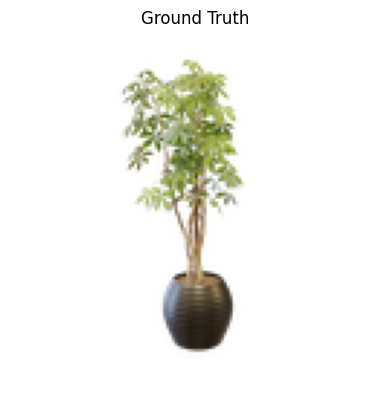

In [6]:

def load_blender_image(dataset_dir, img_size=(128, 128)):
    with open(os.path.join(dataset_dir, 'transforms_train.json'), 'r') as f:
        meta = json.load(f)

    frame = meta['frames'][0]  # Use the first training image
    img_path = os.path.join(dataset_dir, frame['file_path'] + '.png')

    image = Image.open(img_path).resize(img_size, Image.LANCZOS)
    image = np.array(image) / 255.0 # Normalize to [0, 1]

    # Blend alpha channel onto white background
    rgb = image[..., :3] * image[..., 3:] + (1 - image[..., 3:])

    pose = np.array(frame['transform_matrix'])  # camera's pose (position and orientation) in 3D space
    focal = 0.5 * img_size[0] / np.tan(0.5 * meta['camera_angle_x'])
    return rgb, pose, focal

# Path to Blender ficus dataset
ficus_dir = './data/nerf_synthetic/ficus'
image, camera_to_world, focal_length = load_blender_image(ficus_dir, img_size=(128, 128))
height, width = image.shape[:2]



plt.imshow(image)
plt.title('Ground Truth')
plt.axis('off')
plt.show()


## 2. Ray Generation
This step connects the 2D image to the 3D world. For every pixel in the 128x128 image, it calculates a unique 3D ray.
Each ray has an origin (the camera's 3D location) and a direction vector that points from the camera, through that pixel and out into the scene. That results in a set of 10,000 rays, one for each pixel

In [35]:
def generate_camera_rays(height, width, focal_length, camera_to_world):
    # Create a grid of pixel coordinates (i: x-axis, j: y-axis)
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

    # Compute ray directions in camera space
    x = (i - width / 2) / focal_length
    y = -(j - height / 2) / focal_length
    z = -np.ones_like(x)
    directions_camera = np.stack([x, y, z], axis=-1)  # Shape: (H, W, 3)

    # Transform ray directions to world space
    directions_world = directions_camera @ camera_to_world[:3, :3].T

    # All rays originate from the camera origin in world space
    origins_world = np.broadcast_to(camera_to_world[:3, 3], directions_world.shape)

    return origins_world, directions_world

ray_origins, ray_directions = generate_camera_rays(height, width, focal_length, camera_to_world)


## 3. Point Sampling Along Rays
The neural network needs 3D points to evaluate, not just rays. This function takes each of the 10,000 rays and samples 32 distinct 3D points (x, y, z) along its path.
These points are spaced evenly between a near and a far boundary, defining the volume in space where the object is expected to be.


In [ ]:

def sample_points_along_rays(ray_origins, ray_directions, near, far, num_samples):
    z_vals = np.linspace(near, far, num_samples)  # Shape: (N,)

    # Compute 3D sample points along each ray
    # ray_origins: (H, W, 3)
    # ray_directions: (H, W, 3)
    # z_vals: (N,)
    # Resulting points shape: (H, W, N, 3)
    points = ray_origins[..., None, :] + ray_directions[..., None, :] * z_vals[None, None, :, None]

    return points, z_vals

num_samples_per_ray = 32
near_bound, far_bound = 2.0, 6.0
sampled_points, z_values = sample_points_along_rays(ray_origins, ray_directions, near_bound, far_bound, num_samples_per_ray)


## Neural Network Definition
This is the core of the NeRF: a simple neural network. Its job is to act as a "function of the scene." It takes a single 3D coordinate (x, y, z) as input and predicts two things at that specific point in space: its color (r, g, b) and its density (sigma). A high density means the point is opaque, while a low density means it's transparent.

In [37]:
class NeRFNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 4)  # Output: (r, g, b, sigma)
        )

    def forward(self, x):
        return self.mlp(x)

# Instantiate the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeRFNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

## 5. Volume Rendering Function
Volume rendering simulates the way light passes through a semi-transparent medium (like fog, smoke, or 3D scenes) and accumulates color and opacity along a ray.

This is how an image is created from the Neural Network's predictions. For a single ray, it takes the 32 predicted colors and densities from the sampled points. Using the volume rendering equation, it composites them together, correctly blending the colors based on their density and distance. Points closer to the camera can block (occlude) points further away. The final output is a single pixel color for that ray.



In [ ]:


def volume_render_radiance_field(rgb_sigma, z_values, ray_directions):
    """
    Args:
        rgb_sigma (Tensor): Raw output from the network of shape (num_rays, num_samples, 4).
                            The last channel is sigma (density), and the first three are RGB.
        z_values (Tensor): Sampled depth values along each ray, shape (num_samples,).
        ray_directions (Tensor): Ray directions, shape (num_rays, 3).

    """
    # Separate RGB and density (sigma), applying activation functions
    rgb = torch.sigmoid(rgb_sigma[..., :3])          # (num_rays, num_samples, 3)
    # sigma = F.relu(rgb_sigma[..., 3])                # (num_rays, num_samples)
    sigma = F.softplus(rgb_sigma[..., 3])    # (num_rays, num_samples)

    # Compute distances between consecutive samples along each ray
    dists = z_values[1:] - z_values[:-1]             # (num_samples - 1,)
    dists = torch.cat([dists, torch.tensor([1e10], device=z_values.device)])  # (num_samples,)
    dists = dists.unsqueeze(0).expand(ray_directions.shape[0], -1)            # (num_rays, num_samples)

    # Scale distances by the length of each ray
    ray_lengths = torch.norm(ray_directions, dim=-1, keepdim=True)           # (num_rays, 1)
    dists = dists * ray_lengths                                              # (num_rays, num_samples)

    # Compute alpha values from sigma
    alpha = 1.0 - torch.exp(-sigma * dists)                                  # (num_rays, num_samples)

    # Compute transmittance (T) and sample weights
    T = torch.cumprod(
        torch.cat([
            torch.ones((alpha.shape[0], 1), device=alpha.device),
            1.0 - alpha + 1e-10
        ], dim=-1),
        dim=-1
    )[:, :-1]

    weights = alpha * T                                                      # (num_rays, num_samples)

    # Composite RGB values using the weights
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)                    # (num_rays, 3)

    return rgb_map  # Rendered RGB color for each ray, shape (num_rays, 3).


## 6. Prepare Training Data
To train efficiently on a GPU, the data (sampled points, ray directions, and target pixel colors) is "flattened" from 120x120 structure into long, one-dimensional lists.
It also converts the NumPy arrays into PyTorch Tensors.

In [39]:

# Flatten rays and image for batch processing
num_rays = height * width

points_flat = torch.from_numpy(sampled_points.reshape(-1, num_samples_per_ray, 3)).float().to(device)
ray_directions_flat = torch.from_numpy(ray_directions.reshape(-1, 3)).float().to(device)
target_rgb_flat = torch.from_numpy(image.reshape(-1, 3)).float().to(device)

z_values_tensor = torch.from_numpy(z_values).float().to(device)


## 7. Training Loop
This is where the learning happens. The loop repeats num_training_steps times, and in each step it:
- Forward Pass: Feeds all the sampled 3D points to the MLP to get color and density predictions.
- Render: Uses the volume rendering function to turn those predictions into a full image.
- Calculate Loss: Compares the rendered image with the ground truth image using Mean Squared Error (MSE) to see how "wrong" the prediction is.
- Optimize: Uses the error to calculate how to adjust the MLP's weights to make a better prediction in the next step (this is backpropagation).

In [40]:

num_training_steps = 10000
for step in tqdm(range(num_training_steps), desc="Training NeRF"):
    # Predict color and density for all points along all rays
    rgb_sigma = model(points_flat)  # (num_rays, num_samples, 4)
    rgb_sigma = rgb_sigma.view(-1, num_samples_per_ray, 4)

    # Volume render to get final pixel colors
    rendered_rgb = volume_render_radiance_field(rgb_sigma, z_values_tensor, ray_directions_flat)

    # Compute loss
    loss = F.mse_loss(rendered_rgb, target_rgb_flat)

    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f"Step {step:4d} | Loss: {loss.item():.6f}")


Training NeRF:   0%|          | 8/10000 [00:00<04:22, 38.05it/s]

Step    0 | Loss: 0.213687


Training NeRF:   1%|          | 107/10000 [00:02<03:22, 48.79it/s]

Step  100 | Loss: 0.017575


Training NeRF:   2%|▏         | 207/10000 [00:04<03:21, 48.60it/s]

Step  200 | Loss: 0.007388


Training NeRF:   3%|▎         | 307/10000 [00:06<03:20, 48.28it/s]

Step  300 | Loss: 0.005336


Training NeRF:   4%|▍         | 407/10000 [00:08<03:28, 46.08it/s]

Step  400 | Loss: 0.005025


Training NeRF:   5%|▌         | 507/10000 [00:10<03:17, 48.02it/s]

Step  500 | Loss: 0.004813


Training NeRF:   6%|▌         | 607/10000 [00:12<03:16, 47.91it/s]

Step  600 | Loss: 0.004657


Training NeRF:   7%|▋         | 707/10000 [00:14<03:11, 48.42it/s]

Step  700 | Loss: 0.004475


Training NeRF:   8%|▊         | 807/10000 [00:16<03:11, 47.89it/s]

Step  800 | Loss: 0.004334


Training NeRF:   9%|▉         | 907/10000 [00:19<03:07, 48.38it/s]

Step  900 | Loss: 0.004206


Training NeRF:  10%|█         | 1007/10000 [00:21<03:25, 43.66it/s]

Step 1000 | Loss: 0.004075


Training NeRF:  11%|█         | 1107/10000 [00:23<03:14, 45.84it/s]

Step 1100 | Loss: 0.003994


Training NeRF:  12%|█▏        | 1207/10000 [00:25<03:10, 46.08it/s]

Step 1200 | Loss: 0.003940


Training NeRF:  13%|█▎        | 1307/10000 [00:27<02:58, 48.74it/s]

Step 1300 | Loss: 0.003855


Training NeRF:  14%|█▍        | 1407/10000 [00:29<03:02, 47.10it/s]

Step 1400 | Loss: 0.003815


Training NeRF:  15%|█▌        | 1507/10000 [00:31<02:54, 48.64it/s]

Step 1500 | Loss: 0.003769


Training NeRF:  16%|█▌        | 1607/10000 [00:33<03:06, 45.11it/s]

Step 1600 | Loss: 0.003701


Training NeRF:  17%|█▋        | 1707/10000 [00:35<02:51, 48.22it/s]

Step 1700 | Loss: 0.003697


Training NeRF:  18%|█▊        | 1807/10000 [00:38<02:50, 48.06it/s]

Step 1800 | Loss: 0.003646


Training NeRF:  19%|█▉        | 1907/10000 [00:40<02:54, 46.42it/s]

Step 1900 | Loss: 0.003627


Training NeRF:  20%|██        | 2007/10000 [00:42<02:45, 48.25it/s]

Step 2000 | Loss: 0.003624


Training NeRF:  21%|██        | 2107/10000 [00:44<02:50, 46.27it/s]

Step 2100 | Loss: 0.003561


Training NeRF:  22%|██▏       | 2207/10000 [00:46<02:45, 47.12it/s]

Step 2200 | Loss: 0.003545


Training NeRF:  23%|██▎       | 2307/10000 [00:48<02:48, 45.61it/s]

Step 2300 | Loss: 0.003548


Training NeRF:  24%|██▍       | 2407/10000 [00:50<02:39, 47.66it/s]

Step 2400 | Loss: 0.003499


Training NeRF:  25%|██▌       | 2507/10000 [00:52<02:37, 47.60it/s]

Step 2500 | Loss: 0.003493


Training NeRF:  26%|██▌       | 2607/10000 [00:54<02:33, 48.14it/s]

Step 2600 | Loss: 0.003461


Training NeRF:  27%|██▋       | 2707/10000 [00:57<02:32, 47.73it/s]

Step 2700 | Loss: 0.003429


Training NeRF:  28%|██▊       | 2807/10000 [00:59<02:44, 43.65it/s]

Step 2800 | Loss: 0.003415


Training NeRF:  29%|██▉       | 2907/10000 [01:01<02:34, 45.95it/s]

Step 2900 | Loss: 0.003396


Training NeRF:  30%|███       | 3007/10000 [01:03<02:25, 47.93it/s]

Step 3000 | Loss: 0.003417


Training NeRF:  31%|███       | 3108/10000 [01:05<02:26, 47.17it/s]

Step 3100 | Loss: 0.003392


Training NeRF:  32%|███▏      | 3209/10000 [01:07<02:21, 47.97it/s]

Step 3200 | Loss: 0.003384


Training NeRF:  33%|███▎      | 3309/10000 [01:09<02:21, 47.31it/s]

Step 3300 | Loss: 0.003341


Training NeRF:  34%|███▍      | 3409/10000 [01:12<02:17, 48.07it/s]

Step 3400 | Loss: 0.003315


Training NeRF:  35%|███▌      | 3509/10000 [01:14<02:15, 47.90it/s]

Step 3500 | Loss: 0.003326


Training NeRF:  36%|███▌      | 3609/10000 [01:16<02:21, 45.19it/s]

Step 3600 | Loss: 0.003262


Training NeRF:  37%|███▋      | 3709/10000 [01:18<02:11, 48.00it/s]

Step 3700 | Loss: 0.003275


Training NeRF:  38%|███▊      | 3809/10000 [01:20<02:12, 46.88it/s]

Step 3800 | Loss: 0.003216


Training NeRF:  39%|███▉      | 3909/10000 [01:22<02:09, 46.99it/s]

Step 3900 | Loss: 0.003222


Training NeRF:  40%|████      | 4009/10000 [01:24<02:06, 47.37it/s]

Step 4000 | Loss: 0.003215


Training NeRF:  41%|████      | 4109/10000 [01:27<02:04, 47.50it/s]

Step 4100 | Loss: 0.003179


Training NeRF:  42%|████▏     | 4210/10000 [01:29<02:04, 46.49it/s]

Step 4200 | Loss: 0.003154


Training NeRF:  43%|████▎     | 4305/10000 [01:31<02:06, 44.85it/s]

Step 4300 | Loss: 0.003141


Training NeRF:  44%|████▍     | 4410/10000 [01:33<02:01, 46.06it/s]

Step 4400 | Loss: 0.003095


Training NeRF:  45%|████▌     | 4510/10000 [01:35<01:58, 46.24it/s]

Step 4500 | Loss: 0.003137


Training NeRF:  46%|████▌     | 4610/10000 [01:37<01:53, 47.65it/s]

Step 4600 | Loss: 0.003085


Training NeRF:  47%|████▋     | 4710/10000 [01:39<01:48, 48.82it/s]

Step 4700 | Loss: 0.003054


Training NeRF:  48%|████▊     | 4810/10000 [01:41<01:47, 48.09it/s]

Step 4800 | Loss: 0.003079


Training NeRF:  49%|████▉     | 4910/10000 [01:44<01:45, 48.07it/s]

Step 4900 | Loss: 0.003084


Training NeRF:  50%|█████     | 5010/10000 [01:46<01:46, 47.02it/s]

Step 5000 | Loss: 0.003033


Training NeRF:  51%|█████     | 5105/10000 [01:48<01:52, 43.32it/s]

Step 5100 | Loss: 0.003025


Training NeRF:  52%|█████▏    | 5210/10000 [01:50<01:43, 46.25it/s]

Step 5200 | Loss: 0.002988


Training NeRF:  53%|█████▎    | 5310/10000 [01:52<01:39, 47.02it/s]

Step 5300 | Loss: 0.003039


Training NeRF:  54%|█████▍    | 5410/10000 [01:54<01:35, 48.08it/s]

Step 5400 | Loss: 0.003014


Training NeRF:  55%|█████▌    | 5510/10000 [01:56<01:34, 47.69it/s]

Step 5500 | Loss: 0.002955


Training NeRF:  56%|█████▌    | 5610/10000 [01:58<01:31, 47.98it/s]

Step 5600 | Loss: 0.002957


Training NeRF:  57%|█████▋    | 5710/10000 [02:01<01:32, 46.40it/s]

Step 5700 | Loss: 0.002982


Training NeRF:  58%|█████▊    | 5810/10000 [02:03<01:26, 48.20it/s]

Step 5800 | Loss: 0.002968


Training NeRF:  59%|█████▉    | 5910/10000 [02:05<01:24, 48.31it/s]

Step 5900 | Loss: 0.002988


Training NeRF:  60%|██████    | 6010/10000 [02:07<01:27, 45.82it/s]

Step 6000 | Loss: 0.002934


Training NeRF:  61%|██████    | 6110/10000 [02:09<01:20, 48.14it/s]

Step 6100 | Loss: 0.002922


Training NeRF:  62%|██████▏   | 6210/10000 [02:11<01:21, 46.72it/s]

Step 6200 | Loss: 0.002887


Training NeRF:  63%|██████▎   | 6310/10000 [02:13<01:18, 46.85it/s]

Step 6300 | Loss: 0.002889


Training NeRF:  64%|██████▍   | 6410/10000 [02:15<01:14, 48.17it/s]

Step 6400 | Loss: 0.002908


Training NeRF:  65%|██████▌   | 6510/10000 [02:18<01:12, 48.04it/s]

Step 6500 | Loss: 0.002857


Training NeRF:  66%|██████▌   | 6610/10000 [02:20<01:10, 48.11it/s]

Step 6600 | Loss: 0.002850


Training NeRF:  67%|██████▋   | 6710/10000 [02:22<01:10, 46.47it/s]

Step 6700 | Loss: 0.002915


Training NeRF:  68%|██████▊   | 6810/10000 [02:24<01:08, 46.74it/s]

Step 6800 | Loss: 0.002846


Training NeRF:  69%|██████▉   | 6910/10000 [02:26<01:05, 47.13it/s]

Step 6900 | Loss: 0.002834


Training NeRF:  70%|███████   | 7010/10000 [02:28<01:02, 47.96it/s]

Step 7000 | Loss: 0.002868


Training NeRF:  71%|███████   | 7110/10000 [02:30<01:00, 47.62it/s]

Step 7100 | Loss: 0.002822


Training NeRF:  72%|███████▏  | 7210/10000 [02:32<00:58, 47.91it/s]

Step 7200 | Loss: 0.002813


Training NeRF:  73%|███████▎  | 7310/10000 [02:35<00:55, 48.36it/s]

Step 7300 | Loss: 0.002838


Training NeRF:  74%|███████▍  | 7406/10000 [02:37<00:55, 46.51it/s]

Step 7400 | Loss: 0.002861


Training NeRF:  75%|███████▌  | 7506/10000 [02:39<00:55, 44.97it/s]

Step 7500 | Loss: 0.002874


Training NeRF:  76%|███████▌  | 7607/10000 [02:41<00:51, 46.25it/s]

Step 7600 | Loss: 0.002842


Training NeRF:  77%|███████▋  | 7707/10000 [02:43<00:47, 48.37it/s]

Step 7700 | Loss: 0.002846


Training NeRF:  78%|███████▊  | 7807/10000 [02:45<00:46, 47.47it/s]

Step 7800 | Loss: 0.002781


Training NeRF:  79%|███████▉  | 7907/10000 [02:47<00:43, 47.75it/s]

Step 7900 | Loss: 0.002847


Training NeRF:  80%|████████  | 8007/10000 [02:49<00:42, 46.81it/s]

Step 8000 | Loss: 0.002824


Training NeRF:  81%|████████  | 8107/10000 [02:52<00:40, 47.03it/s]

Step 8100 | Loss: 0.002770


Training NeRF:  82%|████████▏ | 8207/10000 [02:54<00:37, 47.71it/s]

Step 8200 | Loss: 0.002776


Training NeRF:  83%|████████▎ | 8307/10000 [02:56<00:36, 46.08it/s]

Step 8300 | Loss: 0.002770


Training NeRF:  84%|████████▍ | 8407/10000 [02:58<00:34, 45.99it/s]

Step 8400 | Loss: 0.002774


Training NeRF:  85%|████████▌ | 8507/10000 [03:00<00:31, 46.98it/s]

Step 8500 | Loss: 0.002755


Training NeRF:  86%|████████▌ | 8607/10000 [03:02<00:30, 46.37it/s]

Step 8600 | Loss: 0.002752


Training NeRF:  87%|████████▋ | 8707/10000 [03:04<00:26, 48.05it/s]

Step 8700 | Loss: 0.002750


Training NeRF:  88%|████████▊ | 8807/10000 [03:07<00:24, 47.97it/s]

Step 8800 | Loss: 0.002786


Training NeRF:  89%|████████▉ | 8907/10000 [03:09<00:23, 46.49it/s]

Step 8900 | Loss: 0.002751


Training NeRF:  90%|█████████ | 9007/10000 [03:11<00:20, 47.51it/s]

Step 9000 | Loss: 0.002743


Training NeRF:  91%|█████████ | 9107/10000 [03:13<00:20, 43.98it/s]

Step 9100 | Loss: 0.002782


Training NeRF:  92%|█████████▏| 9207/10000 [03:15<00:17, 45.25it/s]

Step 9200 | Loss: 0.002776


Training NeRF:  93%|█████████▎| 9307/10000 [03:17<00:14, 47.63it/s]

Step 9300 | Loss: 0.002721


Training NeRF:  94%|█████████▍| 9407/10000 [03:19<00:12, 48.40it/s]

Step 9400 | Loss: 0.002718


Training NeRF:  95%|█████████▌| 9507/10000 [03:22<00:10, 48.33it/s]

Step 9500 | Loss: 0.002714


Training NeRF:  96%|█████████▌| 9607/10000 [03:24<00:08, 47.83it/s]

Step 9600 | Loss: 0.002784


Training NeRF:  97%|█████████▋| 9707/10000 [03:26<00:06, 46.08it/s]

Step 9700 | Loss: 0.002730


Training NeRF:  98%|█████████▊| 9807/10000 [03:28<00:04, 44.77it/s]

Step 9800 | Loss: 0.002754


Training NeRF:  99%|█████████▉| 9907/10000 [03:30<00:01, 48.33it/s]

Step 9900 | Loss: 0.002697


Training NeRF: 100%|██████████| 10000/10000 [03:32<00:00, 47.04it/s]


## 8. Visualization

After the training finishes, this final step takes the model's last rendered image, converts it back into a standard image format, and displays it next to the original ground truth image.


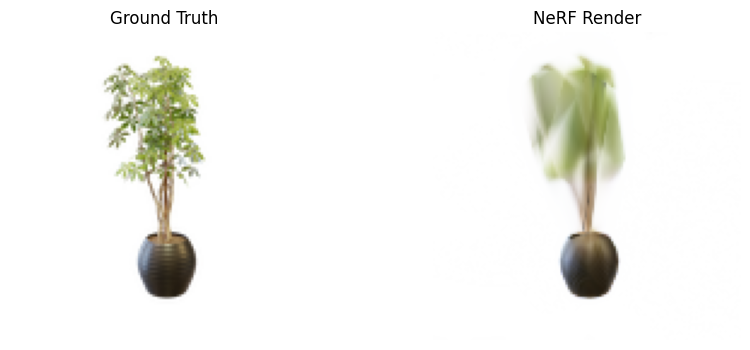

In [41]:
# Reshape the rendered image and display
rendered_image = rendered_rgb.detach().cpu().numpy().reshape(height, width, 3)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('NeRF Render')
plt.imshow(np.clip(rendered_image, 0, 1))
plt.axis('off')
plt.show()